In [1]:
import pandas as pd
import numpy as np

import tqdm

#Depois de pegar o get_ball_possition, usar esse código para separar cada BPI (posse de bola das partidas)

In [2]:
# Ignore warnings
import warnings
import sys

if not sys.warnoptions:
    warnings.simplefilter("ignore")

# Constantes

In [3]:
TEMPO_CONSTANTE = int(167) # Constante de 5 segundos
INVERTER_JOGADORES = False

# Lendo arquivos com quais jogos serão análisados

In [4]:
#Pegando os jogos que serão análisados
jogos = pd.read_csv('jogos_rodados.csv')
jogos.dropna(inplace = True)
jogos_arquivos = jogos.Jogo_2D.unique()

In [5]:
#Separando eventos que foram Passes
def separando_df(df):
    df_p = df[df[4]==1]
    df_p_1 = df_p[df_p[1] <= 14]
    df_p_2 = df_p[df_p[1] > 14]
    
    return df_p_1,df_p_2

In [6]:
def classifier_ball_zone (x_pos, y_pos):
    if x_pos < 0 :
        return -1
    if x_pos <= 27.5:
        if y_pos <= 24.6:
            return 3
        elif y_pos <= 49.2:
            return 2
        else:
            return 1
    elif x_pos <= 55:
        if y_pos <= 24.6:
            return 6
        elif y_pos <= 49.2:
            return 5
        else:
            return 4
    elif x_pos <= 82.5:
        if y_pos <= 24.6:
            return 9
        elif y_pos <= 49.2:
            return 8
        else:
            return 7
    elif x_pos > 82.5:
        if y_pos <= 24.6:
            return 12
        elif y_pos <= 49.2:
            return 11
        else:
            return 10 

In [7]:
# Quebrando o jogo em uma sequência de posses de bola
def get_BPI(all_game):
    """
    Verifica se o frame atual possui uma equipe com posse de bola diferente da equipe do frame anteior
    """
    change_teams = all_game.time_possession.shift(-1) != all_game.time_possession

    global count
    count = -1
    def inc_count(x) :
      global count
      if x :
        count += 1
        return count
      else :    
        return count
    return change_teams.apply(inc_count), change_teams

In [8]:
def apply_classifier_ball_zone(row) :
    return classifier_ball_zone(row[0], row[1])

def classify_ball_zone():
    return ball_positions.loc[:,["2","3"]].apply(apply_classifier_ball_zone, axis = "columns")

In [9]:
def get_zone_get_possession(all_game):
    ball_chance_zone = all_game.loc[0, 'ball_zone']
    zone_get_possesion = [ball_chance_zone]

    aux_true_false = all_game.time_possession != all_game.time_possession.shift(-1)
    #aux_true_false = np.logical_and(model.time_possession != model.time_possession.shift(1),(model.time_possession.shift(1) == 1))

    for row in range(1, all_game.shape[0]) :
        if aux_true_false[row] :
            ball_chance_zone = all_game.loc[row, 'ball_zone']
        zone_get_possesion.append(ball_chance_zone)

    return zone_get_possesion

In [10]:
def zone_validation(all_game):
    if inverter_players():
        in_zone_2 = (all_game.ball_zone == 1) | (all_game.ball_zone == 2) | (all_game.ball_zone == 3)
        in_zone_1 = (all_game.ball_zone == 10) | (all_game.ball_zone == 11) | (all_game.ball_zone == 12)

        #Definindo qual a representação de posse de cada equipe
        tem_2 = all_game.time_possession == 1
        tem_1 = all_game.time_possession == 0
        
    else:
        in_zone_1 = (all_game.ball_zone == 1) | (all_game.ball_zone == 2) | (all_game.ball_zone == 3)
        in_zone_2 = (all_game.ball_zone == 10) | (all_game.ball_zone == 11) | (all_game.ball_zone == 12)

        #Definindo qual a representação de posse de cada equipe
        tem_1 = all_game.time_possession == 1
        tem_2 = all_game.time_possession == 0
    
    return in_zone_1, in_zone_2, tem_1, tem_2

In [11]:
def get_possession_in_zone(BPI_grouped):
    """
    Pega as posses de bola que os últimos 167 frames começaram fora da zona de interesse
    e terminaram dentro dele
    """
    #Pegando as danger_zone do time 1
#     possession_in_zone_1 = BPI_grouped.apply(lambda x: x.iloc[x.ball_zone.size-INI_VALIDA_ZONA_INTERESSE :x.ball_zone.size][(in_zone_1.shift(-1) & tem_1) & (~in_zone_1)])
    possession_in_zone_1 = BPI_grouped.apply(lambda x: x.iloc[x.ball_zone.size-TEMPO_CONSTANTE
                                                              :x.ball_zone.size][(in_zone_1.shift(1) & tem_1) & (~in_zone_1)])

    #Pegando as danger_zone do time 2
    possession_in_zone_2 = BPI_grouped.apply(lambda x: x.iloc[x.ball_zone.size-TEMPO_CONSTANTE 
                                                              :x.ball_zone.size][(in_zone_2.shift(1) & tem_2) & (~in_zone_2)])

    #Juntados todas as danger_zone
    possession_in_zone = pd.concat([possession_in_zone_1, possession_in_zone_2],ignore_index = True)
    
    return possession_in_zone

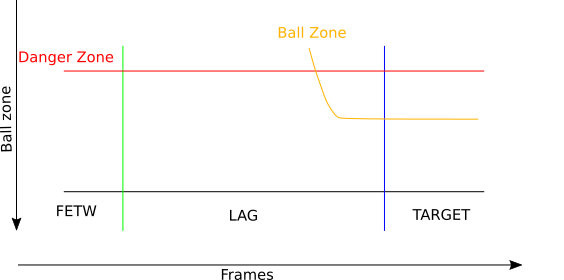

In [12]:
# all_game.iloc[1000:1400]['ball_zone'][(in_zone_2 & tem_2) & (~in_zone_2).shift(-1)]

# all_game.iloc[1000:1400][all_game['ball_zone'] == 12]

# for i, itens in enumerate(all_game.iloc[1100:1200]['ball_zone'].shift(1) != 12):
#     if itens == False:
#         print(i)
#         break
        
# all_game.iloc[1130:1135]

# all_game.iloc[1130:1135]['ball_zone']




In [13]:
# all_game.iloc[1100:1200]['ball_zone'].shift(1) != 12

In [14]:
# # all_game.iloc[1130:1135]['ball_zone'].shift(1) == 12
# all_game.iloc[1130:1135]['ball_zone'].shift(-1) == 12

# (all_game.iloc[1100:1200]['ball_zone'].shift(1) == 12) and (all_game.iloc[1100:1200]['ball_zone'].shift(1) != 12)
# # all_game.iloc[1100:1200]['ball_zone']

# all_game.groupby(all_game.ball_possession_index).apply(lambda x: x.iloc[x.ball_zone.size-TEMPO_CONSTANTE
#                                                               :x.ball_zone.size][(in_zone_1.shift(1) & tem_1) & (~in_zone_1)])

# all_game.groupby(all_game.ball_possession_index).apply(lambda x: x.iloc[x.ball_zone.size-TEMPO_CONSTANTE
#                                                               :x.ball_zone.size][(in_zone_1 & tem_1) & (~in_zone_1).shift(-1)])

# all_game.iloc[all_game.ball_zone.size-TEMPO_CONSTANTE:all_game.ball_zone.size][(in_zone_1 & tem_1)].shift(3)

# ball_possession_index

In [15]:
def get_possession_in_zone_2(BPI_grouped):
    """
    Pega as posses de bola que os últimos 167 frames começaram fora da zona de interesse
    e terminaram dentro dele
    """
    #Pegando as danger_zone do time 1
#     possession_in_zone_1 = BPI_grouped.apply(lambda x: x.iloc[x.ball_zone.size-INI_VALIDA_ZONA_INTERESSE :x.ball_zone.size][(in_zone_1.shift(-1) & tem_1) & (~in_zone_1)])
    possession_in_zone_1 = BPI_grouped.apply(lambda x: x.iloc[TEMPO_CONSTANTE
                                                              :x.ball_zone.size][(in_zone_1.shift(-1) & tem_1) & (~in_zone_1)])

    #Pegando as danger_zone do time 2
    possession_in_zone_2 = BPI_grouped.apply(lambda x: x.iloc[TEMPO_CONSTANTE 
                                                              :x.ball_zone.size][(in_zone_2.shift(-1) & tem_2) & (~in_zone_2)])

    #Juntados todas as danger_zone
    possession_in_zone = pd.concat([possession_in_zone_1, possession_in_zone_2],ignore_index = True)
    
    return possession_in_zone

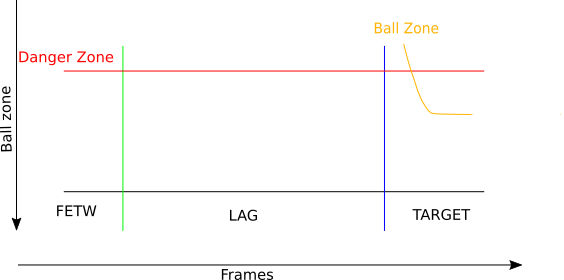

In [16]:
def get_possession_in_zone_3(BPI_grouped):
    """
    Pega as posses de bola que os últimos 167 frames começaram fora da zona de interesse
    e terminaram dentro dele
    """
    #Pegando as danger_zone do time 1
#     possession_in_zone_1 = BPI_grouped.apply(lambda x: x.iloc[x.ball_zone.size-INI_VALIDA_ZONA_INTERESSE :x.ball_zone.size][(in_zone_1.shift(-1) & tem_1) & (~in_zone_1)])
    possession_in_zone_1 = BPI_grouped.apply(lambda x: x.iloc[x.ball_zone.size-TEMPO_CONSTANTE
                                                              :x.ball_zone.size][(in_zone_1.shift(-1) & tem_1) & (~in_zone_1)])

    #Pegando as danger_zone do time 2
    possession_in_zone_2 = BPI_grouped.apply(lambda x: x.iloc[x.ball_zone.size-TEMPO_CONSTANTE 
                                                              :x.ball_zone.size][(in_zone_2.shift(-1) & tem_2) & (~in_zone_2)])

    #Juntados todas as danger_zone
    possession_in_zone = pd.concat([possession_in_zone_1, possession_in_zone_2],ignore_index = True)
    
    return possession_in_zone

In [17]:
# all_game.groupby(all_game.ball_possession_index).apply(lambda x: x.iloc[x.ball_zone.size-TEMPO_CONSTANTE
#                                                               :x.ball_zone.size][(in_zone_1.shift(-1) & tem_1) & (~in_zone_1)])

In [18]:
# all_game.iloc[all_game.ball_zone.size-TEMPO_CONSTANTE:all_game.ball_zone.size][in_zone_1]

In [19]:
# all_game.groupby(all_game.ball_possession_index).apply(lambda x: x.iloc[0] if ).dropna()

In [20]:
def any_frame_in_danger_zone(bpi):
    print(any(bpi.ball_zone[in_zone_1]))
    

In [21]:
# all_game.groupby(all_game.ball_possession_index).apply(lambda x: any_frame_in_danger_zone(x.iloc[x.ball_zone.size-TEMPO_CONSTANTE
#                                                               :x.ball_zone.size][(in_zone_1)]))

In [22]:
def frames_to_time(frame):
    return (frame/100)*3

In [23]:
def set_bpi_target(row):
    if int(row['index']) in possession_in_zone['ball_possession_index'].values:
        return 1
    else:
        return 0

In [24]:
def inverter_players():
    if INVERTER_JOGADORES == True and partida[-1] == '2':
        return True
    else:
        return False

# Extraindo features de todos as partidas

In [25]:
# partida = jogos.Jogo_2D.unique()[0]

# BPI_zones = pd.DataFrame()

# #Importando arquivo contendo a posição da bola juntos dos eventos que ocorreram por frame.
# df = pd.read_csv(f"{path_original}/Jogos/{partida}.ant", sep =('\s+'), header=None)

# #Possição da bola gerada pelo Ranieli
# ball_positions = pd.read_csv(f"{path_original}/ball_position/ball_position_{str(partida)}.csv")
# #     ball_positions = pd.read_csv('ball_position\\ball_position_'+str(partida) + '.csv')

# #Lendo dados das posições dos jogadores
# #     players_possitions = pd.read_csv('Jogos\\'+ str(partida) + 'suav.2d', sep =('\s+'), header=None)
# players_possitions = pd.read_csv(f"{path_original}/Jogos/{str(partida)}suav.2d", sep =('\s+'), header=None)

# #Separando passes
# df_p_1, df_p_2 = separando_df(df)

# #Criando Dataframe Provisório
# all_game = pd.DataFrame(columns=['ball_zone','time_possession','zone_get_possesion'])

In [26]:
path_original = ""

In [27]:
# partida = 'REDSCAT1'

In [28]:
# df = pd.read_csv(f"{path_original}/Jogos/{partida}.ant", sep =('\s+'), header=None)

In [29]:
# players_possitions = pd.read_csv(f"{path_original}/Jogos/{str(partida)}suav.2d", sep =('\s+'), header=None)

In [30]:
all_BPI = pd.DataFrame()
list_jogos = []
path_original = "."

for partida in tqdm.tqdm(jogos.Jogo_2D.unique()):
# for partida in tqdm.tqdm([jogos.Jogo_2D.unique()[0]]):
    #DataFrame os valores por zona para cada BPI
    BPI_zones = pd.DataFrame()
    
    #Importando arquivo contendo a posição da bola juntos dos eventos que ocorreram por frame.
    df = pd.read_csv(f"{path_original}/jogos/{partida}.ant", sep =('\s+'), header=None)

    #Possição da bola gerada pelo Ranieli
    ball_positions = pd.read_csv(f"{path_original}/ball_position/ball_position_{str(partida)}.csv")
#     ball_positions = pd.read_csv('ball_position\\ball_position_'+str(partida) + '.csv')

    #Lendo dados das posições dos jogadores
#     players_possitions = pd.read_csv('Jogos\\'+ str(partida) + 'suav.2d', sep =('\s+'), header=None)
    players_possitions = pd.read_csv(f"{path_original}/jogos/{str(partida)}suav.2d", sep =('\s+'), header=None)
    
    #Separando passes
    df_p_1, df_p_2 = separando_df(df)
    
    #Criando Dataframe Provisório
    all_game = pd.DataFrame(columns=['ball_zone','time_possession','zone_get_possesion'])
    
    #Separando os dados da posse de bola
    all_game['time_possession'] = ball_positions.loc[:,'1'].astype('int32')
    
    #Pegando indice de cada BPI
    all_game["ball_possession_index"], change_teams = get_BPI(all_game)
    
    #Classificando a bola da zona
    all_game["ball_zone"] = classify_ball_zone()
    
    #Pegando a zona que o time conseguiu a posse
    all_game['zone_get_possesion'] = get_zone_get_possession(all_game)
    
    #Ajustando indice do DataFrame
    all_game.reset_index(inplace = True)
    all_game.columns = ['frame', 'ball_zone', 'time_possession', 'zone_get_possesion','ball_possession_index']
    
    # Adiconando diferença entre o começo da posição da bola e dos jogadores
    BPI_zones["frame"] = change_teams[int(ball_positions.loc[0][0]):].loc[change_teams == True].index
        
    #Calculo FETW do BPI
    BPI_zones['FETW_end'] = BPI_zones.apply(lambda x: x["frame"] + TEMPO_CONSTANTE, axis=1)
    
    BPI_zones['LAG_start'] = BPI_zones.apply(lambda x: x["FETW_end"] + 1, axis=1)
    
    #Final da posse de bola
    BPI_zones['frame_end'] = BPI_zones.apply(lambda x: x.shift(-1))['frame']-1
    
    #Calculo LAG do BPI
    BPI_zones['LAG_end'] = BPI_zones.apply(lambda x: x["frame_end"] - TEMPO_CONSTANTE - 1, axis=1)
    
    BPI_zones['Target_start'] = BPI_zones.apply(lambda x: x["LAG_end"] + 1, axis=1)
    
    #Tamanho da posse de bola
    BPI_zones['interval_frame_size'] = BPI_zones.apply(lambda x: x['frame_end'] - x['frame'],axis=1)
    
    #Tempo da posse de bola em segundos
    BPI_zones['interval_time'] = BPI_zones['interval_frame_size'].apply(frames_to_time)
    
    #Posse de cada time
    BPI_zones['team_possession'] = all_game[[i in BPI_zones.frame.astype(int).values for i in all_game['frame']]].time_possession.values
       
    #Regra que define se chegou no target ou não
    in_zone_1, in_zone_2, tem_1, tem_2 = zone_validation(all_game)
    
    #Separando posse de bola por cada equipe (Atacando ou defendendo)
    possession_in_zone = get_possession_in_zone(all_game.groupby(all_game.ball_possession_index))
    
    #Identificando os BPIs que chegaram no target
    BPI_zones['target'] = BPI_zones.reset_index().apply(lambda x: set_bpi_target(x),1)
    
    #Colocando a partida no dataframe
    BPI_zones['partida'] = partida
    
    list_jogos.append(BPI_zones)
    

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:29<00:00, 29.44s/it]


In [31]:
#Criando Dataframe com todos os jogos
for jogo in list_jogos:
    all_BPI = pd.concat([all_BPI, jogo])

In [32]:
# Teste de consistencia de FETW
assert all_BPI.dropna()[all_BPI.dropna().apply(lambda x: int(x['frame']) > int(x['frame_end']),1)].index.size == 0, 'Existem BPI com frame inicial maior que o final do BPI'
assert all_BPI.dropna()[all_BPI.dropna().apply(lambda x: int(x['frame']) > int(x['FETW_end']),1)].index.size == 0, 'Existem BPIs com frame inicial maior que o final do FETW'

In [33]:
#Colocando indice das amostras
all_BPI.reset_index(inplace = True)

In [34]:
# all_BPI['interval_time'].plot.hist()

In [35]:
all_BPI.to_csv('all_games_other_games.csv')